# Pytorch Lightning Framework for training S+Z Galaxy Classifiers

## Imports

In [17]:
import gc
from enum import Enum
import torch
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger,CSVLogger
import shap

from ChiralityClassifier import ChiralityClassifier
from dataset_utils import *
from metrics_utils import *

## Options

In [3]:
class datasets(Enum):
    FULL_DATASET = 0 #Use all 600,000 galaxies in GZ1 catalog
    CUT_DATASET = 1 #Use cut of 200,000 galaxies, with pre-selected test data and downsampled train data
    BEST_SUBSET = 2 #Select N best S,Z & other galaxies, evenly split
    LOCAL_SUBSET = 3 #Use local cache of 1500 galaxies
    FULL_DESI_DATASET = 4 #Use all 7 million galaxies in DESI catalog, minus those that appear in cut catalog (predict only)
    CUT_TEST_DATASET = 5 #The testing dataset from the CUT_DATASET (predict only)

class modes(Enum):
    TRAIN = 0 #Train on a dataset
    TEST = 1 #Test an existing saved model on a labelled dataset
    PREDICT = 2 #Use an existing saved model on an labelled/unlabelled dataset

DATASET = datasets.LOCAL_SUBSET #Select which dataset to train on, or if testing/predicting, which dataset the model was trained on
MODE = modes.TEST #Select which mode

PREDICT_DATASET = datasets.LOCAL_SUBSET #If predicting, predict this dataset
SET_CHIRALITY = None #Set to None unless you want to use galaxies from the CUT_DATASET's test dataset with only S and Z galaxies at a set chirality violation (predict only)

# Models:
#resnet18,resnet34,resnet50,resnet101,resnet152,
#ce_resnet50,lenet,g_resnet18,g_resnet50,g_lenet,g_resnet18_old
MODEL_NAME = "resnet18"
CUSTOM_ID = "nr"

USE_TENSORBOARD = True #Log to tensorboard as well as csv logger
SAVE_MODEL = True #Save model weights to .pt file
REPEAT_RUNS = 1#Set to 1 for 1 run
IMG_SIZE = 160 #This is the output size of the generated image array
NUM_WORKERS = 6 #Number of workers in dataloader (usually set to no of CPU cores - 1)
MAX_IMAGES = -1 #Max number of images to load (-1 for all)
FLIP_EQUIVARIANCE = False #Enable flip-equivariance (g_resnet models only)
CUSTOM_PREDICT = False #Use Jia et al (2023) flipped predict function (g_resnet models only)
RANDOM_ROTATE = False #Randomly rotate images between 0-360 degrees in training/testing

#HYPERPARAMS
BATCH_SIZE = 100 #Number of images per batch
LEARNING_RATE = 0.0001
MAX_EPOCHS = 60

PATHS = dict(
    METRICS_PATH = "../Metrics",
    LOG_PATH = "../Code/lightning_logs",
    FULL_DATA_PATH =  "/share/nas2/walml/galaxy_zoo/decals/dr8/jpg",
    LOCAL_SUBSET_DATA_PATH =  "../Data/Subset",
    FULL_CATALOG_PATH =  "../Data/gz1_desi_cross_cat.csv",
    FULL_DESI_CATALOG_PATH =  "../Data/desi_full_cat.parquet",
    CUT_CATALOG_TEST_PATH =  "../Data/gz1_desi_cross_cat_testing.csv",
    CUT_CATALOG_TRAIN_PATH = "../Data/gz1_desi_cross_cat_train_val_downsample.csv",
    BEST_SUBSET_CATALOG_PATH =  "../Data/gz1_desi_cross_cat_best_subset.csv",
    LOCAL_SUBSET_CATALOG_PATH =  "../Data/gz1_desi_cross_cat_local_subset.csv",
)

torch.set_float32_matmul_precision("medium")
if len(CUSTOM_ID) == 0:
    MODEL_ID = f"{MODEL_NAME}_{DATASET.name.lower()}"
else:
     MODEL_ID = f"{MODEL_NAME}_{DATASET.name.lower()}_{CUSTOM_ID}"
print(f"********** Running model {MODEL_ID} in mode {MODE.name.lower()} ***********")
if MODE != modes.TRAIN:
    USE_TENSORBOARD = False #Don"t log to tensorboard if not training
    SAVE_MODEL = False #Don"t save weights if testing or predicting model
    RANDOM_ROTATE = False #Do not add random rotations in testing or predicting

********** Running model resnet18_local_subset_nr in mode shap ***********


## GPU Test

In [4]:
device = get_device()

Using pytorch 2.2.1. CPU cores available on device: 8
Using device: cpu


## Reading in data

In [5]:
if MODE == modes.PREDICT:
    datamodule = generate_datamodule(PREDICT_DATASET,MODE,PATHS,datasets,modes,IMG_SIZE,BATCH_SIZE,NUM_WORKERS,MAX_IMAGES,RANDOM_ROTATE,SET_CHIRALITY)
    datamodule.prepare_data()
    datamodule.setup(stage='predict')
else:
    datamodule = generate_datamodule(DATASET,MODE,PATHS,datasets,modes,IMG_SIZE,BATCH_SIZE,NUM_WORKERS,MAX_IMAGES,RANDOM_ROTATE)
    datamodule.prepare_data()
    datamodule.setup()

Created 1499 galaxy filepaths


## Code to run

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Partition explainer: 2it [00:38, 38.13s/it]               


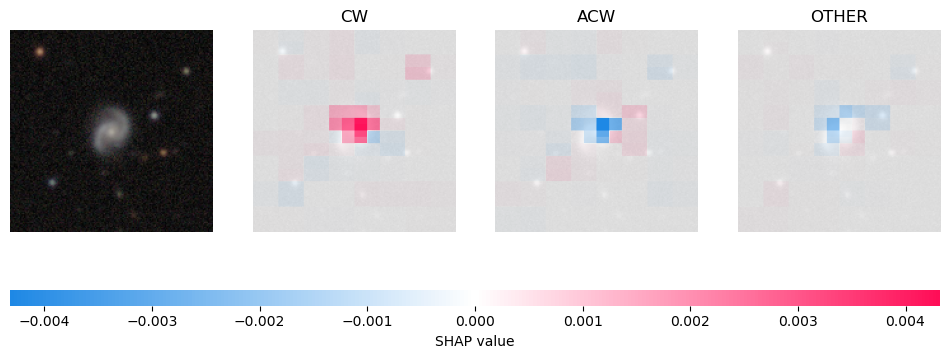

In [16]:
for run in range(0,REPEAT_RUNS):
    
    save_dir = f"{PATHS['METRICS_PATH']}/{MODEL_ID}/version_{run}"
    MODEL_PATH = f"{save_dir}/model.pt"
    create_folder(save_dir)

    model = ChiralityClassifier(
        num_classes=(2 if (MODEL_NAME=="ce_resnet50" or CUSTOM_PREDICT) else 3), #2 for Jia et al version
        model_version=MODEL_NAME,
        optimizer="adamw",
        scheduler  ="steplr",
        lr=LEARNING_RATE,
        weight_decay=0,
        step_size=5,
        gamma=0.85,
        weights=(MODEL_PATH if MODE != modes.TRAIN else None),
        graph_save_path=(f"{save_dir}/val_matrix.png" if MODE == modes.TRAIN else f"{save_dir}/{MODE.name.lower()}_matrix.png"),
        flip_eq=FLIP_EQUIVARIANCE,
        custom_predict = CUSTOM_PREDICT
    )

    tb_logger = TensorBoardLogger(PATHS["LOG_PATH"], name=MODEL_ID,version=f"version_{run}_{MODE.name.lower()}")
    csv_logger = CSVLogger(PATHS["LOG_PATH"],name=MODEL_ID,version=f"version_{run}_{MODE.name.lower()}")
    trainer = pl.Trainer(
        accelerator=("gpu" if device.type=="cuda" else "cpu"),
        max_epochs=MAX_EPOCHS,
        devices=1,
        logger=([tb_logger,csv_logger] if USE_TENSORBOARD else csv_logger),
        default_root_dir=f"{PATHS['LOG_PATH']}/{MODEL_ID}",
        enable_checkpointing=False,
    )

    #compiled_model = torch.compile(model, backend="eager")
    
    if MODE==modes.TRAIN:
        trainer.fit(model,train_dataloaders=datamodule.train_dataloader(),val_dataloaders=datamodule.val_dataloader())
        trainer.test(model,dataloaders=datamodule.val_dataloader())

        if SAVE_MODEL:
            torch.save(trainer.model.state_dict(), MODEL_PATH)
        
    elif MODE==modes.TEST:
        trainer.test(model,dataloaders=datamodule.test_dataloader())
        
    elif MODE==modes.PREDICT:
        predictions = trainer.predict(model,dataloaders=datamodule.predict_dataloader())
        if SET_CHIRALITY is not None:
            predict_save_path = f"{save_dir}/{PREDICT_DATASET.name.lower()}_CVIOL_{SET_CHIRALITY}_predictions.csv"
        else:
            predict_save_path = f"{save_dir}/{PREDICT_DATASET.name.lower()}_predictions.csv"
        if os.path.exists(predict_save_path):
            os.remove(predict_save_path)
        for batch in predictions: #Save predictions
            batch = pd.DataFrame(torch.softmax(batch,dim=1))
            batch.to_csv(predict_save_path,mode='a', index=False, header=False)

    if MODE != modes.PREDICT and MODE != modes.SHAP and SET_CHIRALITY is None:
        #Save cleaned up logs file to Metrics folder & save graph
        save_metrics_from_logger(MODEL_ID,PATHS["LOG_PATH"],PATHS['METRICS_PATH'],version=run,mode=MODE.name.lower(),save=True)  
        if MODE==modes.TRAIN:
            plot_train_metrics(MODEL_ID,PATHS['METRICS_PATH'],version=run,show=False,save=True)

In [ ]:
#Dereference all objects, clear cuda cache and run garbage collection
datamodule=None
model=None
trainer=None
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

12093